In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('cleaned_online_retail_transactions.csv', parse_dates=['InvoiceDate'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


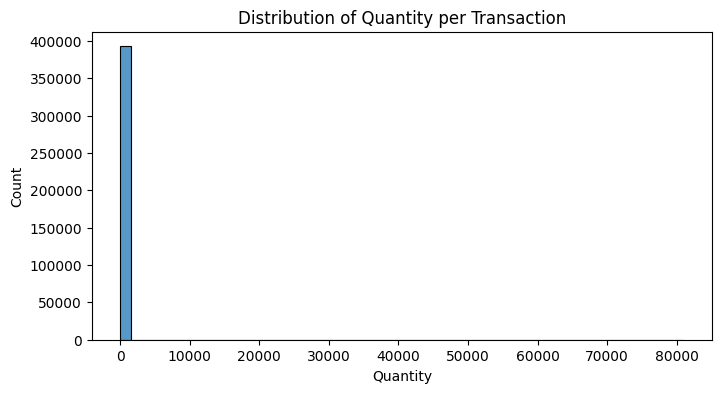

In [3]:
plt.figure(figsize=(8,4))
sns.histplot(df['Quantity'], bins=50)
plt.title('Distribution of Quantity per Transaction')
plt.xlabel('Quantity')
plt.show()

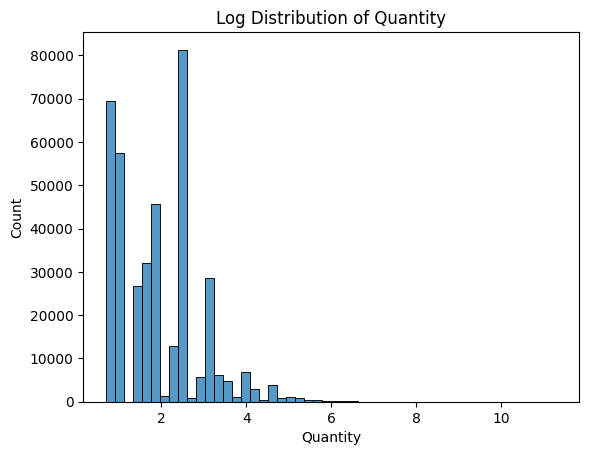

In [4]:
sns.histplot(np.log1p(df['Quantity']), bins=50)
plt.title('Log Distribution of Quantity')
plt.show()

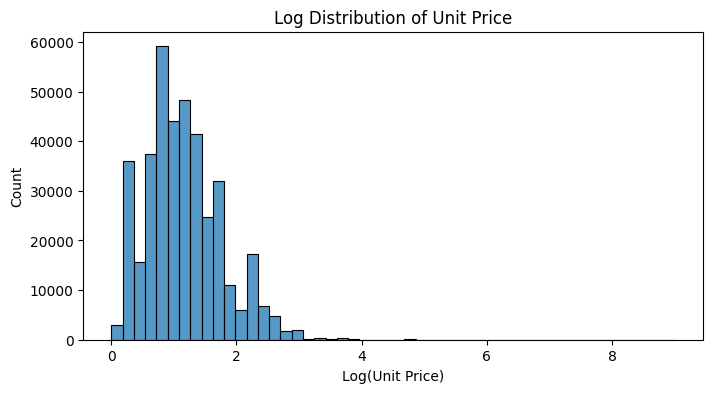

In [5]:
plt.figure(figsize=(8,4))
sns.histplot(np.log1p(df['UnitPrice']), bins=50)
plt.title('Log Distribution of Unit Price')
plt.xlabel('Log(Unit Price)')
plt.show()

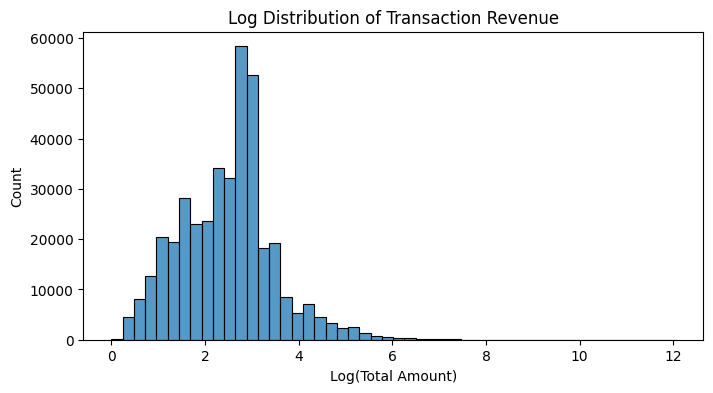

In [6]:
plt.figure(figsize=(8,4))
sns.histplot(np.log1p(df['TotalAmount']), bins=50)
plt.title('Log Distribution of Transaction Revenue')
plt.xlabel('Log(Total Amount)')
plt.show()

In [7]:
customer_summary = df.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum',
    'InvoiceDate': ['min', 'max']
})

customer_summary.columns = ['Frequency', 'Monetary', 'FirstPurchase', 'LastPurchase']
customer_summary.reset_index(inplace=True)

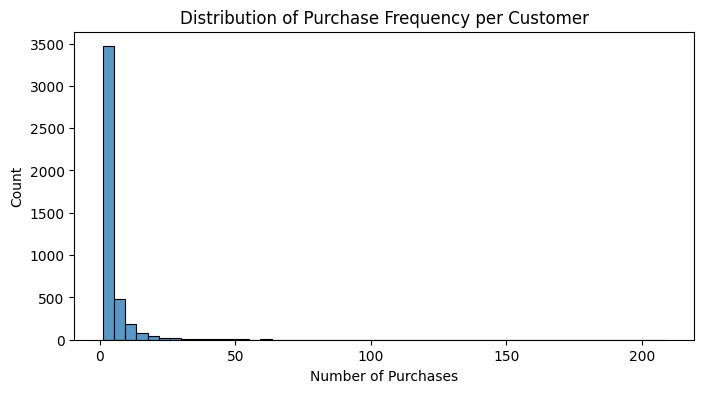

In [8]:
plt.figure(figsize=(8,4))
sns.histplot(customer_summary['Frequency'], bins=50)
plt.title('Distribution of Purchase Frequency per Customer')
plt.xlabel('Number of Purchases')
plt.show()

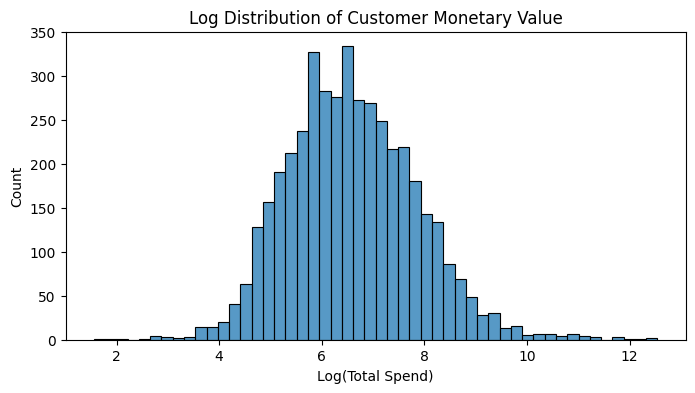

In [9]:
plt.figure(figsize=(8,4))
sns.histplot(np.log1p(customer_summary['Monetary']), bins=50)
plt.title('Log Distribution of Customer Monetary Value')
plt.xlabel('Log(Total Spend)')
plt.show()

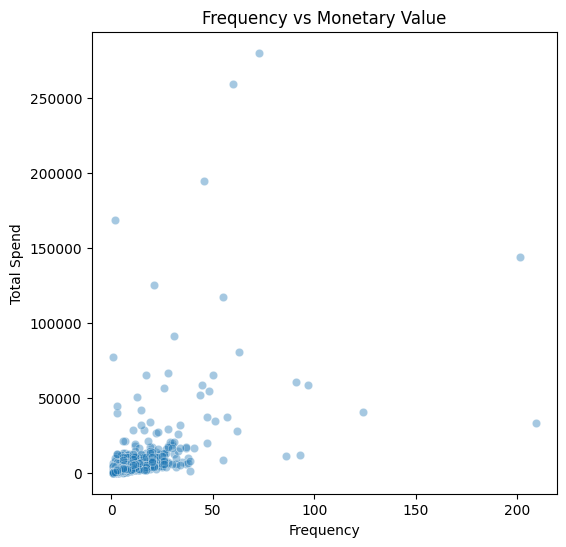

In [10]:
plt.figure(figsize=(6,6))
sns.scatterplot(
    x=customer_summary['Frequency'],
    y=customer_summary['Monetary'],
    alpha=0.4
)
plt.title('Frequency vs Monetary Value')
plt.xlabel('Frequency')
plt.ylabel('Total Spend')
plt.show()

In [11]:
customer_summary = customer_summary.sort_values('Monetary', ascending=False)
customer_summary['CumulativeRevenue'] = customer_summary['Monetary'].cumsum()
customer_summary['CumulativeRevenuePct'] = (
    customer_summary['CumulativeRevenue'] / customer_summary['Monetary'].sum()
)

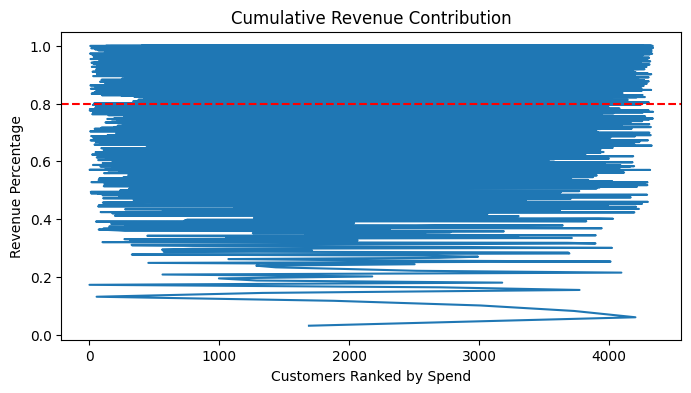

In [12]:
plt.figure(figsize=(8,4))
plt.plot(customer_summary['CumulativeRevenuePct'])
plt.axhline(0.8, color='red', linestyle='--')
plt.title('Cumulative Revenue Contribution')
plt.ylabel('Revenue Percentage')
plt.xlabel('Customers Ranked by Spend')
plt.show()

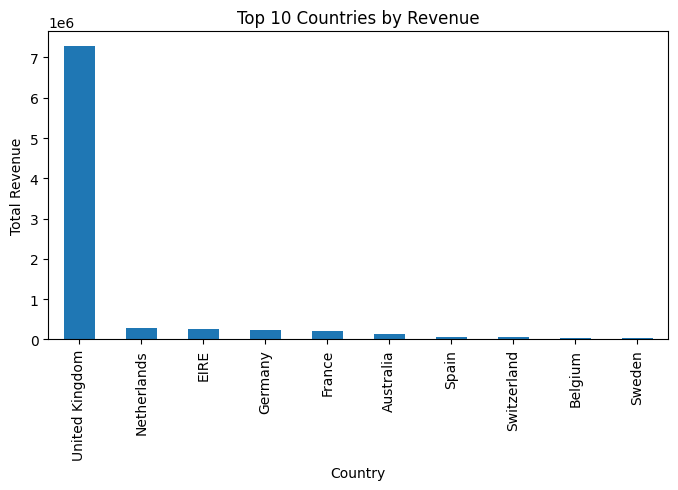

In [13]:
country_revenue = df.groupby('Country')['TotalAmount'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(8,4))
country_revenue.plot(kind='bar')
plt.title('Top 10 Countries by Revenue')
plt.ylabel('Total Revenue')
plt.show()

In [14]:
# Outlier Detection 
num_cols = df.select_dtypes(include=[np.number]).columns

outlier_rows = set()
summary = []
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    mask = (df[col] < lower) | (df[col] > upper)
    count = mask.sum()
    summary.append((col, int(count), round(count / len(df) * 100, 3)))
    outlier_rows.update(df.index[mask].tolist())

summary_df = pd.DataFrame(summary, columns=['column','outlier_count','outlier_pct']).set_index('column').sort_values('outlier_count', ascending=False)
print(summary_df)
print(f"\nRows with any numeric-column IQR outlier: {len(outlier_rows)}")
# show a few example outlier rows (if you want)
if outlier_rows:
    display(df.loc[sorted(outlier_rows)].head())

             outlier_count  outlier_pct
column                                 
UnitPrice            34112        8.687
TotalAmount          31231        7.953
Quantity             25616        6.523
InvoiceNo                0        0.000
CustomerID               0        0.000

Rows with any numeric-column IQR outlier: 68967


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom,15.30
12,536367,48187,DOORMAT NEW ENGLAND,4,2010-12-01 08:34:00,7.95,13047,United Kingdom,31.80
13,536367,21777,RECIPE BOX WITH METAL HEART,4,2010-12-01 08:34:00,7.95,13047,United Kingdom,31.80
23,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,United Kingdom,54.08
24,536367,22622,BOX OF VINTAGE ALPHABET BLOCKS,2,2010-12-01 08:34:00,9.95,13047,United Kingdom,19.90


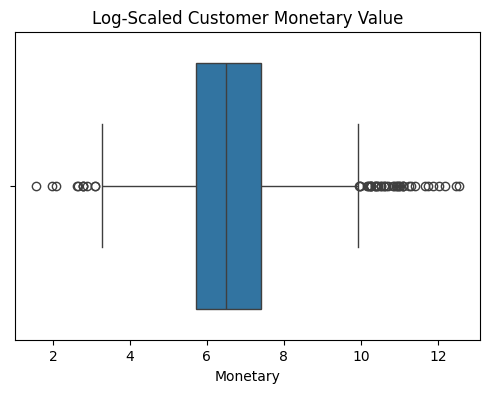

In [15]:
plt.figure(figsize=(6,4))
sns.boxplot(x=np.log1p(customer_summary['Monetary']))
plt.title('Log-Scaled Customer Monetary Value')
plt.show()

In [16]:
customer_eda = df.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',
    'Quantity': 'sum',
    'TotalAmount': 'sum',
    'InvoiceDate': ['min', 'max']
})

customer_eda.columns = [
    'Frequency',
    'TotalQuantity',
    'Monetary',
    'FirstPurchase',
    'LastPurchase'
]

customer_eda.reset_index(inplace=True)


In [17]:
rfm_corr = customer_eda[['Recency', 'Frequency', 'Monetary']].corr()

plt.figure(figsize=(6,4))
sns.heatmap(rfm_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix (RFM)')
plt.show()

KeyError: "['Recency'] not in index"

In [ ]:
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

customer_eda['Recency'] = (
    reference_date - customer_eda['LastPurchase']
).dt.days
